## FINK Lightcurve Plotting

The objective of this notebook is to test out plotting optical ligthcurves for the crossmatched sources identified by FINK. Here, I can edit things in isolation of a larger notebook that contains other bits of code unrelated to optical light curve plotting.

NOTE: the plot_photometry() function defined in this notebook produces a 'None' object if vasttools is imported before the plot is made for some reason.

In [1]:
    #import os
    #import requests
    #import pandas as pd
    #from io import StringIO
    #import numpy as np
    #import matplotlib.pyplot as plt
#from vasttools.pipeline import Pipeline
#from vasttools.query import Query
    #from bokeh.io import output_notebook
    #from bokeh.plotting import show
    #from astropy.coordinates import Angle, SkyCoord
    #from astropy import units as u
    #output_notebook()

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

In [3]:
os.chdir('Project_VAST_FINK')
os.getcwd()

'/home/jovyan/work/Project_VAST_FINK'

In [4]:
cmf = pd.read_pickle('Fink_2020_sources_matched_to_VAST_all_sources.pickle')

In [5]:
AGN_Family=[
'AGN',
'AGN_Candidate',
'QSO',
'QSO_Candidate',
'Seyfert',
'Seyfert_1',
'Seyfert_2',
'Blazar',
'BLLac',
'Blazar_Candidate',
'RadioG',
'LINER'
]

Unknown_Family=[
'Unknown'
]

Galaxy_Family=[
'Galaxy',
'EmG',
'HII_G',
'GroupG',
'GinGroup',
'GinCl',
'GinPair',
'BClG',
'PartofG'
]

Stars_Family=[
'Star',
'RRLyr',
'Candidate_RRLyr',
'EB*',
'Candidate_EB*',
'WD*',
'LMXB',
'CataclyV*',
'low-mass*'
]

Supernovae_Family=[
'SN',
'SN candidate'
]

Radio_Family=[
'Radio',
'Radio(cm)'
]

Multiwavelength_Family=[
'Blue',
'UV',
'X'
]

Solar_System_Family=[
'Solar System',
'Solar System MPC',
'Solar System candidate',
]

In [6]:
Source_Families=[] #define an empty array
for i, row in cmf.iterrows(): #'i' represents the first index in cmf.iterrows, 'row' is the second
    x=row['class'] #this pulls out the class column from eachrow
    for j in AGN_Family: #for all the classes listed in the AGN family
        if x==j: #if it matches the class of the row
            Source_Families.append('AGN') #add 'AGN' to the empty array
    else: #otherwise, check the other families to see if it matches
        for j in Unknown_Family:
            if x==j:
                Source_Families.append('Unknown')
        else:
            for j in Galaxy_Family:
                if x==j:
                    Source_Families.append('Galaxy')
            else:
                for j in Stars_Family:
                    if x==j:
                        Source_Families.append('Star')
                else:
                    for j in Supernovae_Family:
                        if x==j:
                            Source_Families.append('Supernova')
                    else:
                        for j in Radio_Family:
                            if x==j:
                                Source_Families.append('Radio')
                        else:
                            for j in Multiwavelength_Family:
                                if x==j:
                                    Source_Families.append('Multiwavelength')
                            else:
                                for j in Solar_System_Family:
                                    if x==j:
                                        Source_Families.append('Solar System')
                                    
cmf['family']=Source_Families

In [7]:
#cmf.groupby('family').size().sort_values(ascending=False)

In [8]:
#were going to test some FINK querying with the smallest family: 'Stars'
my_sources=cmf.query('family == "AGN"')
my_sources

,objectId,matched_id,class,cdsxmatch,ra,dec,family
1,ZTF18abtjmuc,3800801,Seyfert_1,Seyfert_1,312.923125,0.859951,AGN
2,ZTF18abwwswg,3183786,QSO,QSO,356.166843,-0.542217,AGN
6,ZTF18acvkdtz,3440328,QSO,QSO,218.815233,2.539290,AGN
8,ZTF18aczersz,3438778,QSO,QSO,202.003044,2.455322,AGN
12,ZTF19aainjyb,3465921,BLLac,BLLac,40.234092,-5.078465,AGN
...,...,...,...,...,...,...,...
1759,ZTF20acaraky,3796834,QSO,QSO,33.374515,-5.360879,AGN
1761,ZTF20acdcick,3321302,QSO,QSO,350.769231,-1.846684,AGN
1763,ZTF20acekiug,3727622,QSO,QSO,26.982498,-4.306445,AGN
1769,ZTF20acpcmmy,3595707,LINER,LINER,339.171540,0.042716,AGN


So what I want to do here is query all the FINK data for the catalogue sources, from a specific family or not, then select one of those sources to have their light curve plotted.

In [18]:
#retreiving object data for several objects at once using the objectId list (with upperlim):
Idlist=my_sources['objectId'].to_list()

#defining column array for cutouts
cutouts=[
'b:cutoutScience_stampData',
'b:cutoutTemplate_stampData',
'b:cutoutDifference_stampData'
]

#this is the request made to the fink portal to pull out the info for each source
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF18acetvcr',
    'output-format': 'json',
    'withcutouts': 'True',
    'cols': ','.join(cutouts),
    'withupperlim': 'True' #important for lightcurve plotting
  }
)

In [19]:
#reads in json file data as DataFrame. fsd stands for 'FINK source data'
fsd=pd.read_json(StringIO(r.content.decode()))

Seems like a lot of empty cells? is that intentional or a bug? This is only present when the "upperlim" condition is added into the request

In [20]:
#defining the photometry plotting function here to save having to rerun it everytime:

def plot_photometry(pdf):
    fig = plt.figure(figsize=(15, 6))

    colordic = {1: 'C0', 2: 'C1'}

    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='v', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()

Now, we parse out the specific source we want to plot, which is going to involve selecting the multiple rows
attributed to a specific source within fsd, preserving it as a DataFrame, then feeding it into the 'plot_photometry' function.

In [21]:
#This is fairly simple, we just specify a ZTF ID from our fsd list:
ID='ZTF18acetvcr'

#then define a new variable 'fsd_source, which is just all the rows in fsd such that the key 'i:objectId' is our ID of interest:
fsd_source=fsd[fsd['i:objectId'] == ID]

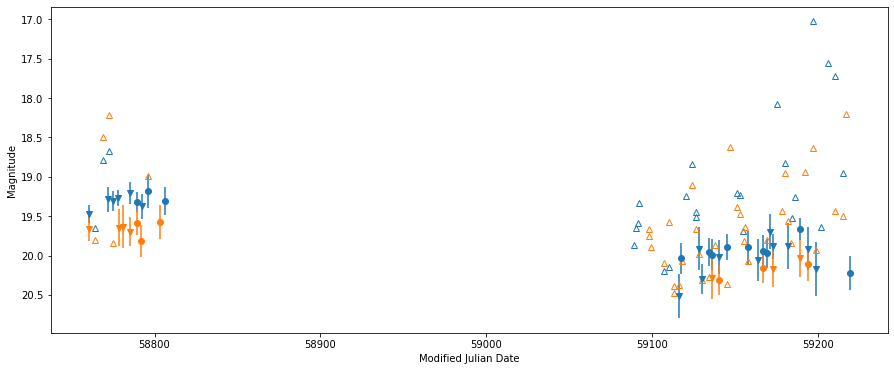

In [22]:
plot_photometry(fsd_source)

In [15]:
from vasttools.pipeline import Pipeline
from vasttools.query import Query

# FINK Cutouts

In this secton, I'm going to retrieve the PNG cutouts for the source whose lighturve I've just plotted:

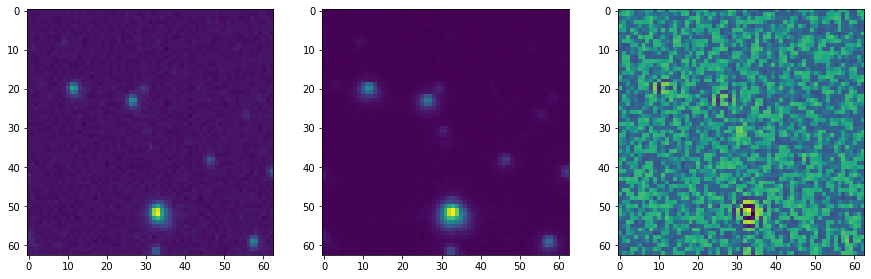

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for col in cutouts:
    data = fsd_source[col].values[0]
    axes[cutouts.index(col)].imshow(np.arcsinh(data))